In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import bets
import os
import glob
import datetime as dt
import time
#import ot
import json
import requests
import statsmodels.api as sm 
from tqdm import tqdm
pd.set_option('display.float_format', lambda x: '%.3f' % x)
nba = bets.nba()
import seaborn as sns
import matplotlib.pyplot as plt
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from nba_api.stats.endpoints import leaguegamefinder,BoxScoreSummaryV2,LeagueDashOppPtShot,PlayerProfileV2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
def reload_table(table,filepath=None,data=None):
   
    try:
        nba.conn.execute('DROP TABLE {}'.format(table))
        nba.conn.commit()
    except:
        print('No table to delete, creating {}'.format(table))
    if filepath != None:
        file = open(filepath,'r').read()
        try:
            nba.conn.execute(file)
        except:
            '{} table already exists'.format(table)
    nba.insert_data(data,table)

#### EDA

What do we want to know:
- Team info
    1. home court advantage?
    2. what is the proportion of games that win by 6+/11+/15+/26+/31+
    3. quarter win distributions
    4. rest, will need rest since last game, number of games in 3/4/5 nights
    

In [ ]:
## What do games spreads look like 6/11/26 point victories - landmarks in espn

In [28]:
tm = pd.read_sql('select * from team_game',nba.conn)

In [29]:
tm['ptDiff'] = tm.game_points_scored - tm.points_allowed

In [30]:
tm[tm.ptDiff >= 1].ptDiff.describe([x/100 for x in range(10,110,10)])

count   8289.000
mean      11.801
std        8.819
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       12.000
70%       15.000
80%       18.000
90%       24.000
100%      73.000
max       73.000
Name: ptDiff, dtype: float64

2017-18
count   1230.000
mean      11.128
std        8.183
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        7.000
50%        9.000
60%       11.000
70%       14.000
80%       17.000
90%       22.000
100%      61.000
max       61.000
Name: ptDiff, dtype: float64


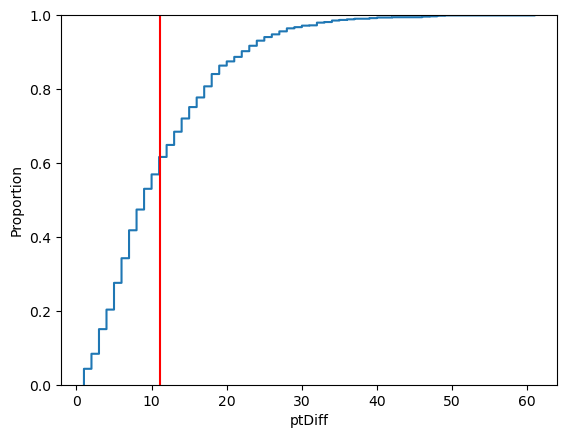

2018-19
count   1230.000
mean      11.739
std        8.779
min        1.000
10%        2.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.400
70%       15.000
80%       19.000
90%       25.000
100%      56.000
max       56.000
Name: ptDiff, dtype: float64


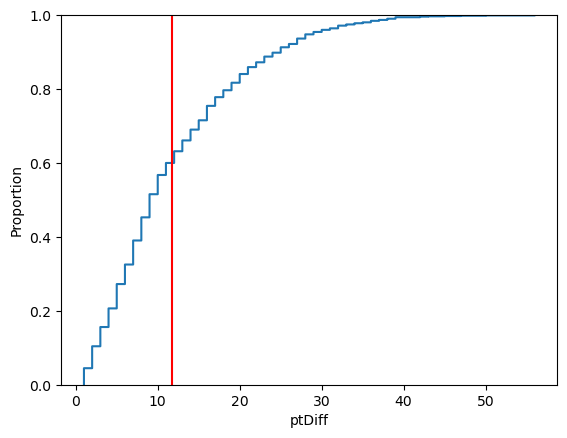

2019-20
count   1059.000
mean      11.413
std        8.535
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.000
70%       14.000
80%       17.000
90%       23.000
100%      49.000
max       49.000
Name: ptDiff, dtype: float64


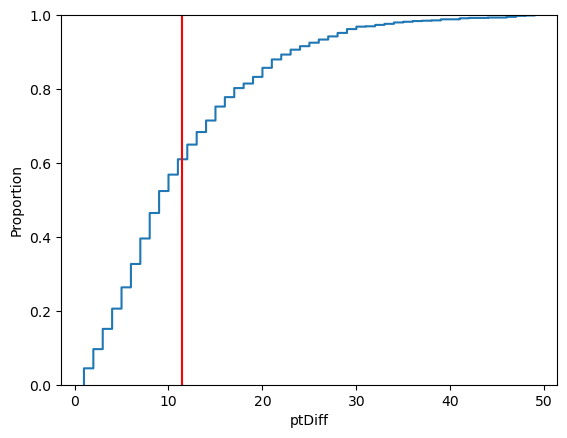

2020-21
count   1080.000
mean      12.184
std        9.103
min        1.000
10%        3.000
20%        4.000
30%        6.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       25.000
100%      57.000
max       57.000
Name: ptDiff, dtype: float64


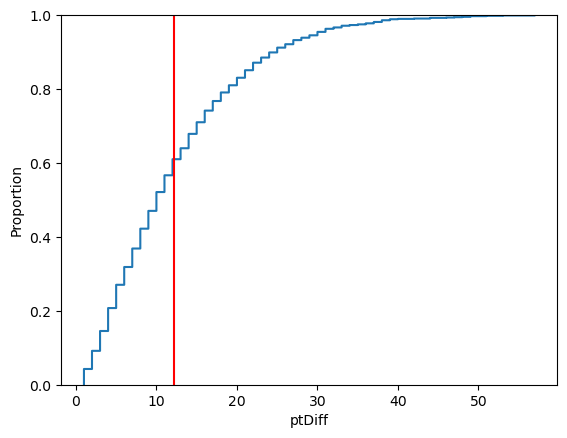

2021-22
count   1230.000
mean      12.373
std        9.176
min        1.000
10%        3.000
20%        5.000
30%        6.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       26.000
100%      73.000
max       73.000
Name: ptDiff, dtype: float64


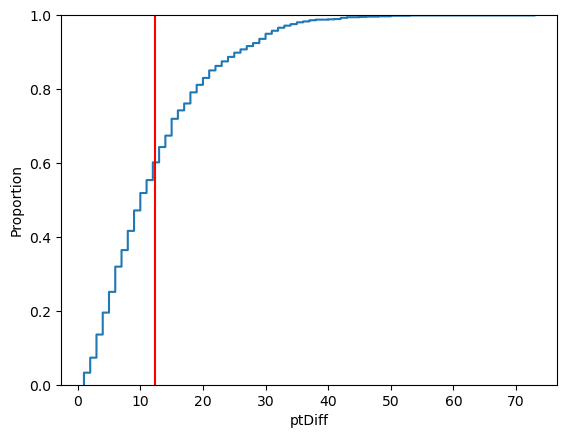

2022-23
count   1230.000
mean      11.181
std        8.245
min        1.000
10%        2.900
20%        4.000
30%        6.000
40%        8.000
50%        9.000
60%       11.000
70%       14.000
80%       18.000
90%       22.000
100%      56.000
max       56.000
Name: ptDiff, dtype: float64


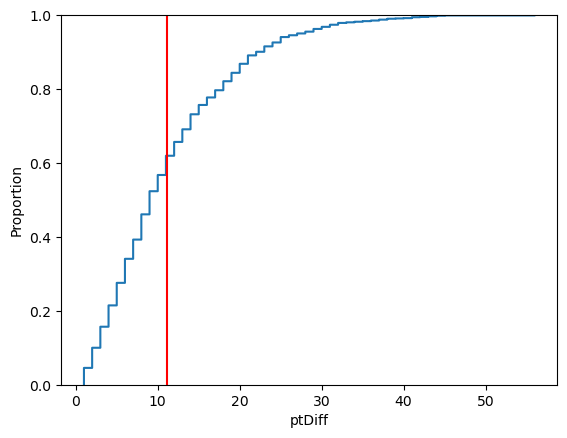

2023-24
count   1230.000
mean      12.584
std        9.529
min        1.000
10%        3.000
20%        5.000
30%        7.000
40%        8.000
50%       10.000
60%       12.000
70%       15.000
80%       19.000
90%       26.000
100%      62.000
max       62.000
Name: ptDiff, dtype: float64


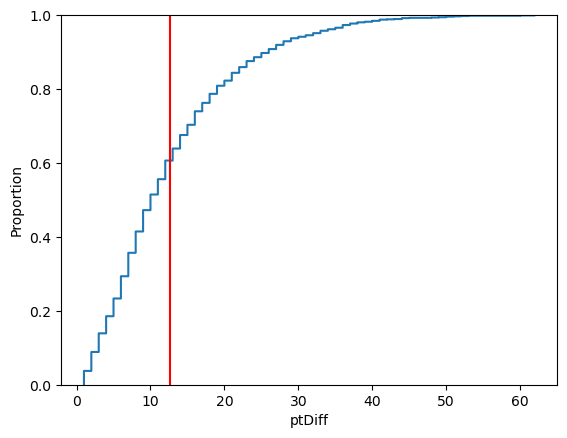

In [31]:
for season in tm.season.unique():
    print(season)
    df = tm[(tm.ptDiff>0) & (tm.season==season)]
    print(df.ptDiff.describe([x/100 for x in range(10,110,10)]))
    sns.ecdfplot(df.ptDiff)
    plt.vlines(x=df.ptDiff.mean(),ymin=0,ymax=1,colors='red')
    plt.show()

In [32]:
#what does 
def pyth_win_exp(pf,pa):
    return np.round(pf ** 16.5 / (pf ** 16.5 + pa ** 16.5),3)

In [83]:
f20 = tm[tm.game_number < 20]
f20wins = f20.groupby(['season','team']).win.value_counts(normalize=True).reset_index(name='wperc')
f20wins = f20wins[f20wins.win==1].drop('win',axis=1)

In [85]:
pyth = pyth_win_exp(f20.groupby(['season','team']).game_points_scored.sum(), f20.groupby(['season','team']).points_allowed.sum()).reset_index(name='pythPerc')

In [86]:
f20wins = f20wins.merge(pyth,how='inner',on=['season','team'])

In [87]:
f20wins

,season,team,wperc,pythPerc
0,2017-18,ATL,0.211,0.330
1,2017-18,BKN,0.368,0.393
2,2017-18,BOS,0.842,0.772
3,2017-18,CHA,0.421,0.471
4,2017-18,CHI,0.158,0.120
...,...,...,...,...
205,2023-24,SAC,0.579,0.474
206,2023-24,SAS,0.158,0.149
207,2023-24,TOR,0.474,0.475
208,2023-24,UTA,0.316,0.268


In [88]:
wPerDf = (tm.groupby(['season','team']).win.sum() / tm.groupby(['season','team']).game_id.nunique()).reset_index(name='actualWPerc')

In [89]:
df = f20wins.merge(wPerDf,how='left',on=['season','team'])

In [90]:
df.actualWPerc

0     0.293
1     0.341
2     0.671
3     0.439
4     0.329
       ... 
205   0.561
206   0.268
207   0.305
208   0.378
209   0.183
Name: actualWPerc, Length: 210, dtype: float64

In [91]:
(df.pythPerc - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean        0.200
std        11.073
min       -40.793
10%       -12.185
20%        -8.520
30%        -6.014
40%        -2.889
50%         0.110
60%         3.002
70%         6.491
80%         9.879
90%        13.525
100%       37.189
max        37.189
dtype: float64

In [94]:
(df.wperc - df.actualWPerc).describe([x/100 for x in range(10,110,10)]) * 100

count   21000.000
mean       -0.003
std        10.104
min       -28.113
10%       -11.692
20%        -8.626
30%        -5.905
40%        -2.062
50%        -0.610
60%         1.430
70%         5.150
80%         8.254
90%        13.183
100%       29.020
max        29.020
dtype: float64

In [95]:
ols = sm.regression.linear_model.OLS
linear_model = ols(endog=df.actualWPerc,exog = df.pythPerc).fit() 
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            actualWPerc   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              4615.
Date:                Tue, 03 Sep 2024   Prob (F-statistic):                   1.95e-144
Time:                        19:45:57   Log-Likelihood:                          169.18
No. Observations:                 210   AIC:                                     -336.4
Df Residuals:                     209   BIC:                                     -333.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pythPerc       0.9571      0.014     67.933      0.000       0.929       0.985
==============================================================================
Omnibus:                        3.614   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                4.276
Skew:                           0.043   Prob(JB):                        0.118
Kurtosis:                       3.694   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# looking at these it seems that 20 games 

In [97]:
f20['ptDiff'] = f20.game_points_scored - f20.points_allowed

/var/folders/y5/cm5rrvr94yx214kzmtmsbvz40000gn/T/ipykernel_31422/1106797319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f20['ptDiff'] = f20.game_points_scored - f20.points_allowed


In [98]:
lg = tm[tm.game_number >= 20]

In [100]:
lgw = lg.groupby(['season','team']).win.value_counts(normalize=True).reset_index(name='lgWinperc')
lgw = lgw[lgw.win==1].drop('win',axis=1)

In [101]:
df = df.merge(lgw,how='left',on=['season','team'])

In [105]:
df

,season,team,wperc,pythPerc,actualWPerc,lgWinperc
0,2017-18,ATL,0.211,0.330,0.293,0.317
1,2017-18,BKN,0.368,0.393,0.341,0.333
2,2017-18,BOS,0.842,0.772,0.671,0.619
3,2017-18,CHA,0.421,0.471,0.439,0.444
4,2017-18,CHI,0.158,0.120,0.329,0.381
...,...,...,...,...,...,...
205,2023-24,SAC,0.579,0.474,0.561,0.556
206,2023-24,SAS,0.158,0.149,0.268,0.302
207,2023-24,TOR,0.474,0.475,0.305,0.254
208,2023-24,UTA,0.316,0.268,0.378,0.397


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


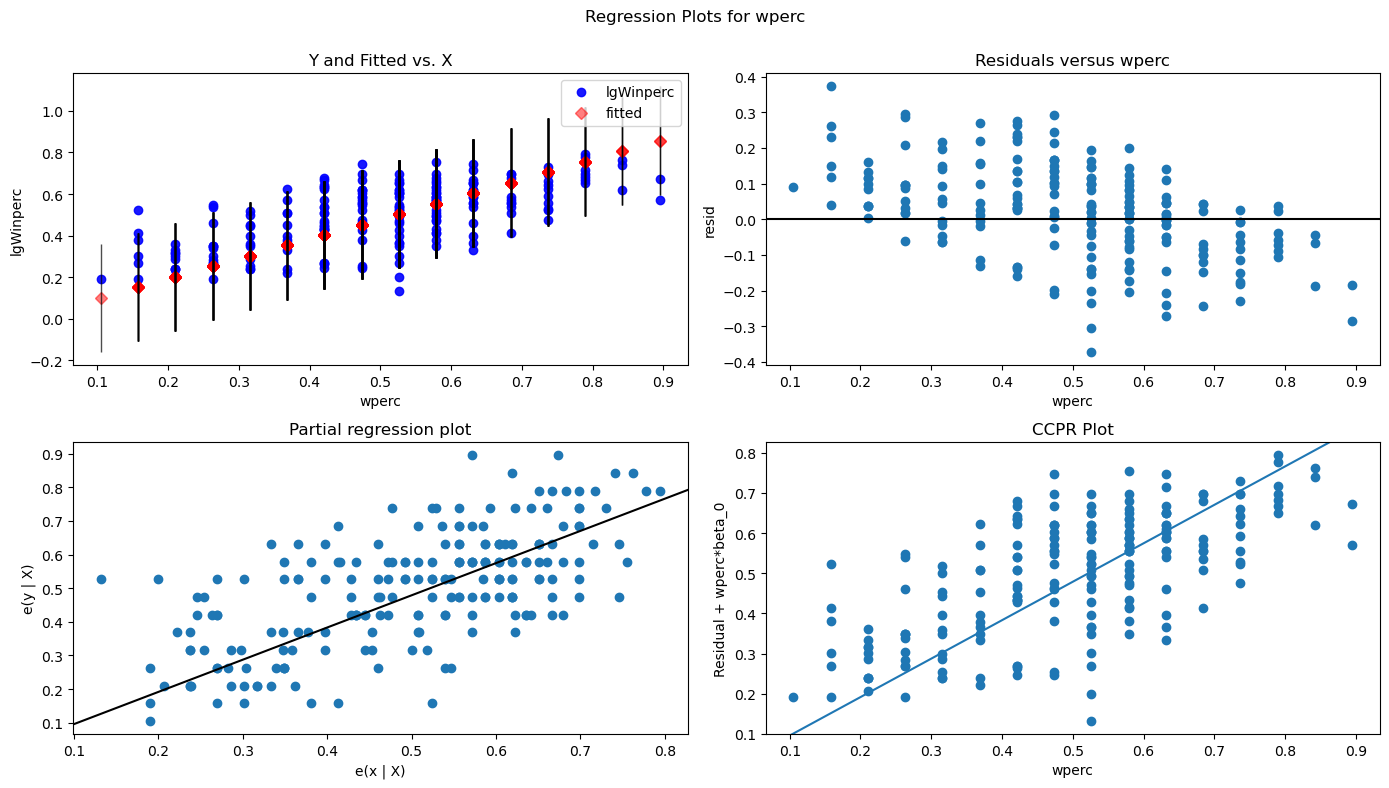

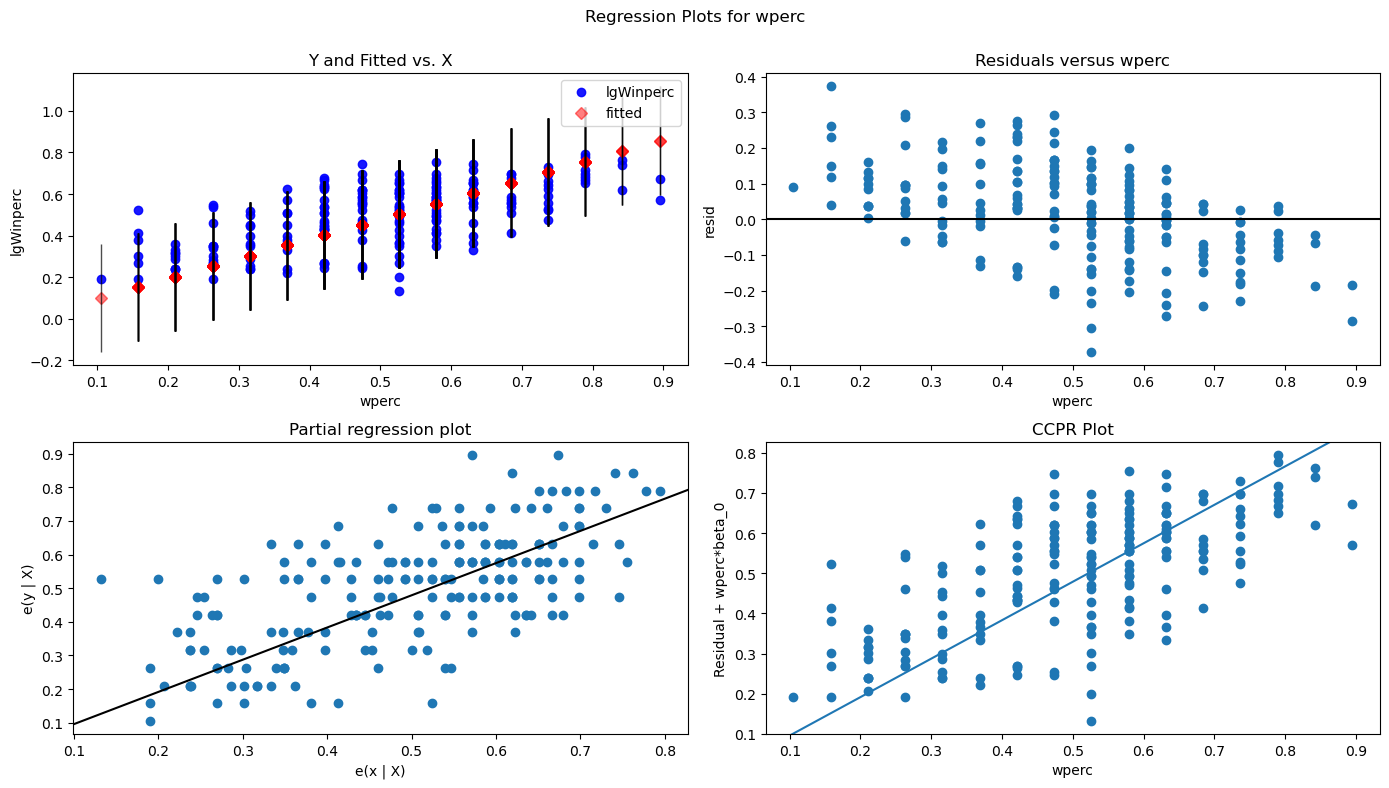

In [114]:
linear_model = ols(endog = df.lgWinperc, exog= df.wperc, 
                   ).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'wperc',
                             fig=fig)

In [115]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              lgWinperc   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              3083.
Date:                Tue, 03 Sep 2024   Prob (F-statistic):                   4.26e-127
Time:                        19:49:56   Log-Likelihood:                          128.38
No. Observations:                 210   AIC:                                     -254.8
Df Residuals:                     209   BIC:                                     -251.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wperc          0.9575      0.017     55.529      0.000       0.924       0.991
==============================================================================
Omnibus:                        1.236   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                1.120
Skew:                          -0.179   Prob(JB):                        0.571
Kurtosis:                       3.002   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


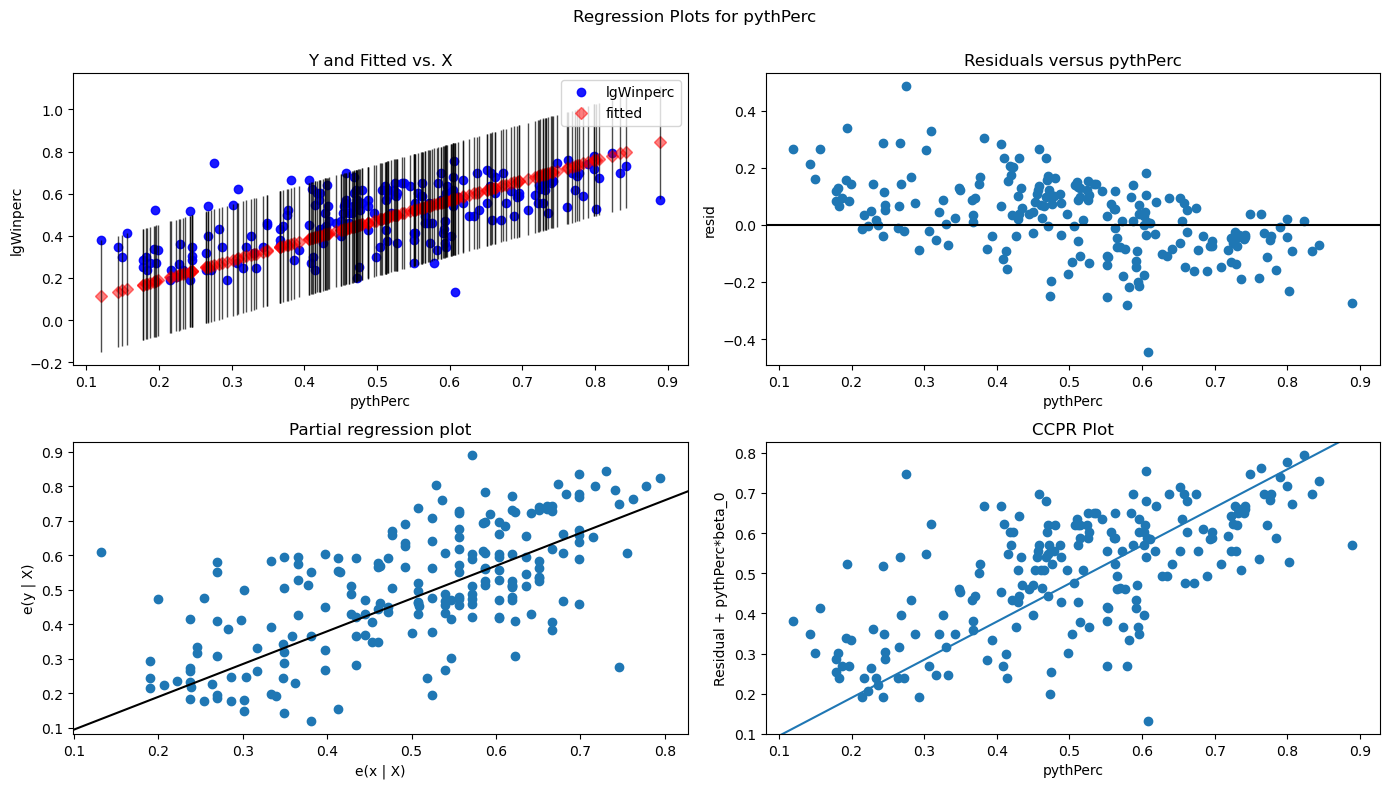

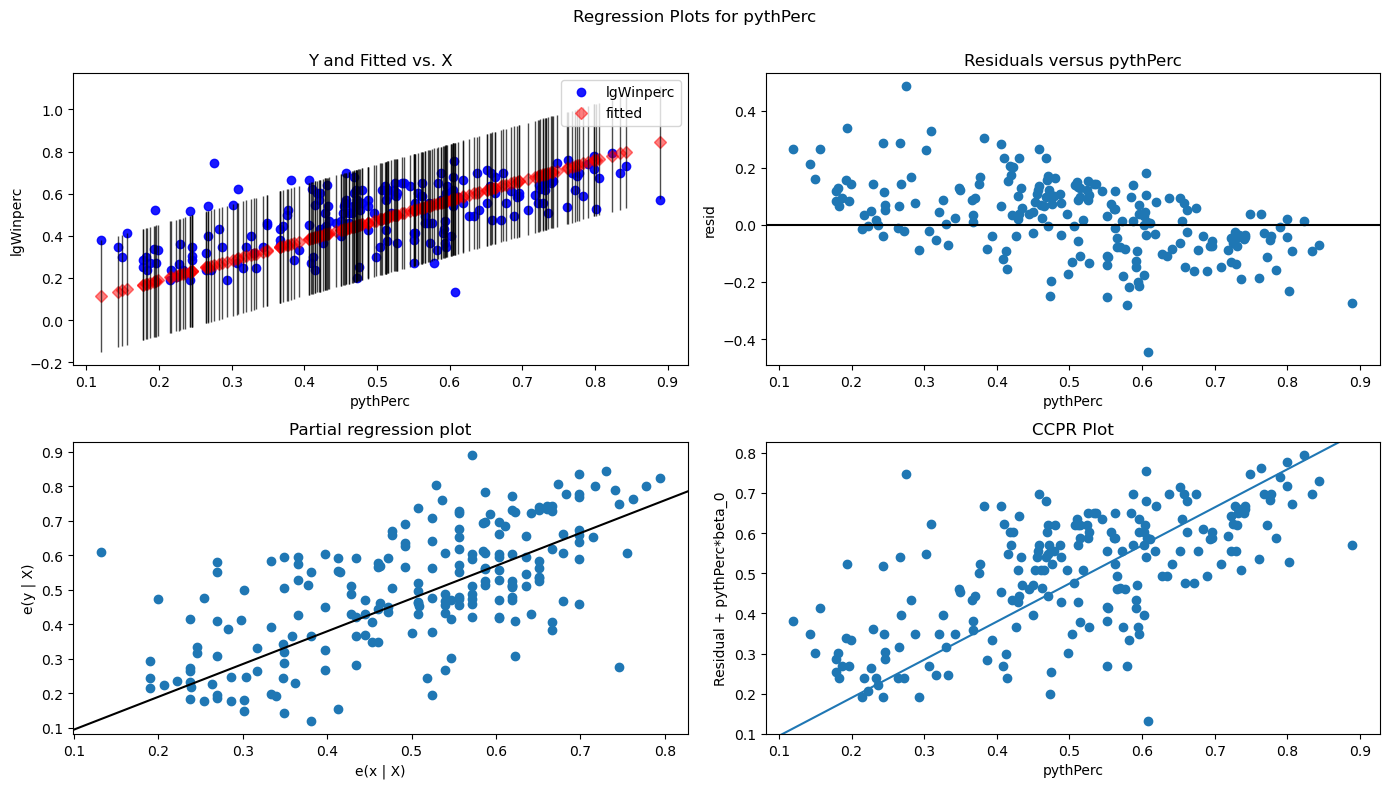

In [116]:
linear_model = ols(endog = df.lgWinperc,exog = df.pythPerc, 
                  ).fit() 
fig = plt.figure(figsize=(14, 8)) 
sm.graphics.plot_regress_exog(linear_model, 
                                    'pythPerc',
                             fig=fig)

In [117]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              lgWinperc   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              2952.
Date:                Tue, 03 Sep 2024   Prob (F-statistic):                   3.01e-125
Time:                        19:50:05   Log-Likelihood:                          124.10
No. Observations:                 210   AIC:                                     -246.2
Df Residuals:                     209   BIC:                                     -242.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pythPerc       0.9488      0.017     54.333      0.000       0.914       0.983
==============================================================================
Omnibus:                        3.174   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.205   Jarque-Bera (JB):                3.577
Skew:                          -0.016   Prob(JB):                        0.167
Kurtosis:                       3.639   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
sortedVals = ['10','11','12','01','02','03','04','05']

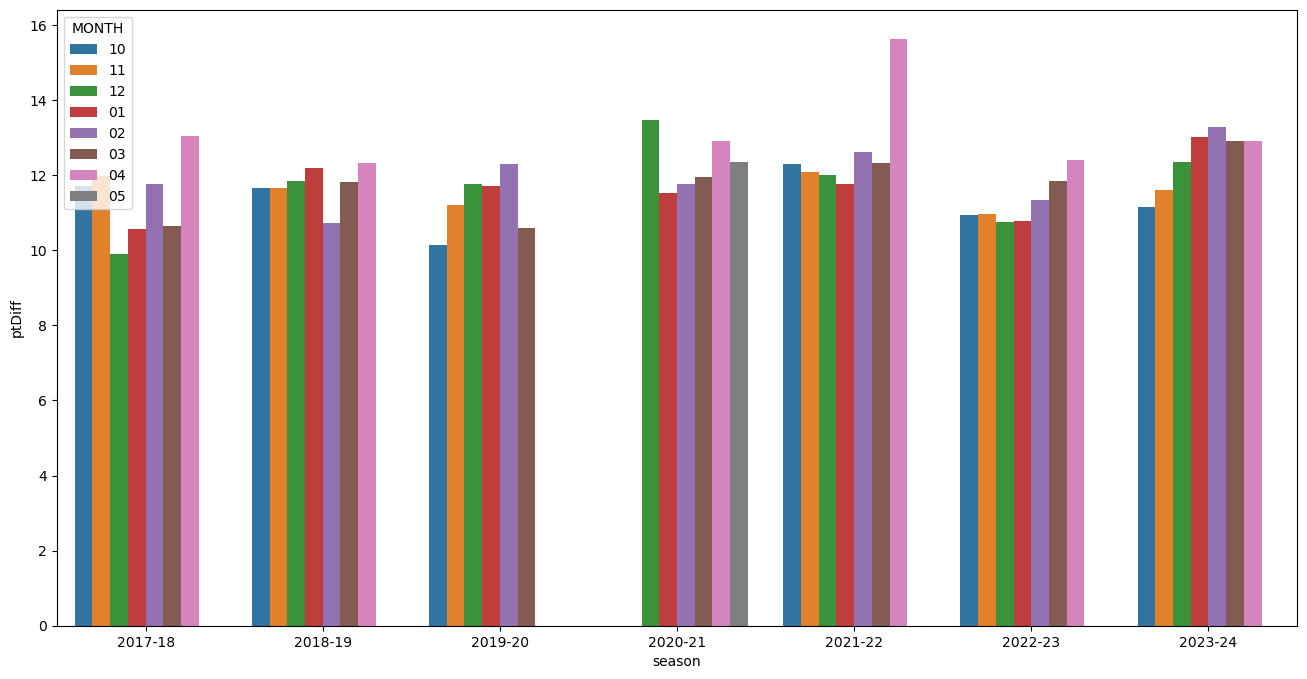

In [120]:

data = tm[tm.win==1].groupby(['season','MONTH']).ptDiff.mean().reset_index()
plt.figure(figsize = (16,8))
sns.barplot(data,x = 'season', y = 'ptDiff',hue='MONTH',hue_order=sortedVals)
plt.show()

 It does seem to increase through the year as april tends to be a high month for spreads.
 2024 there is sentiment that there was a change in refereeing

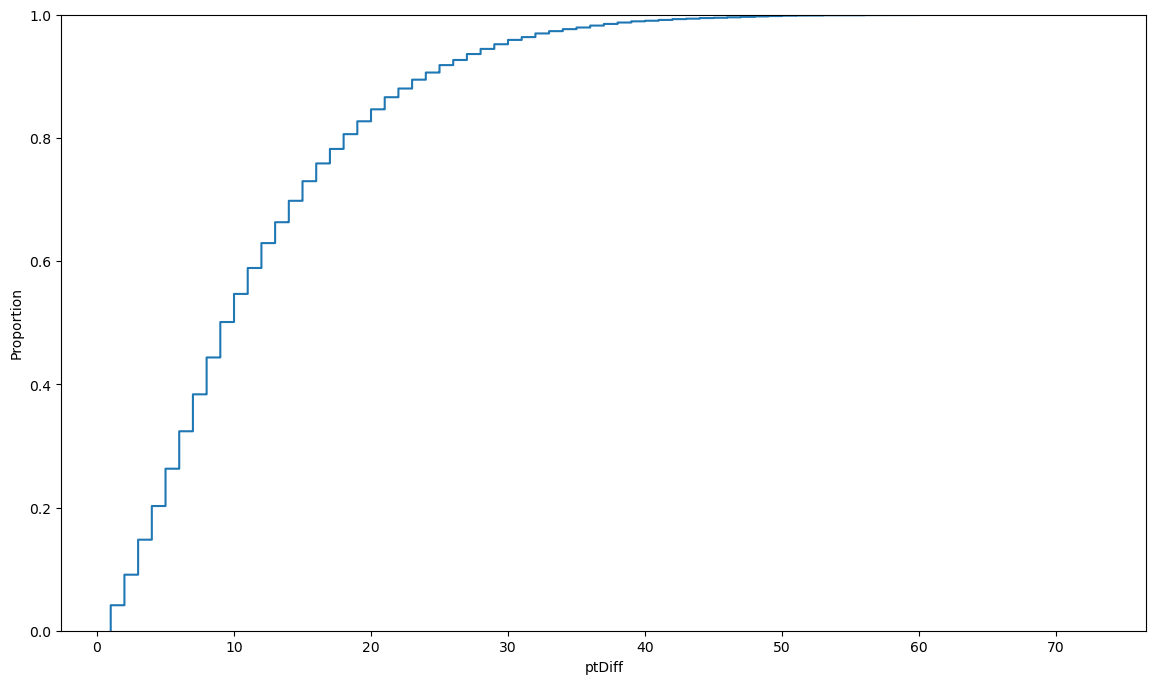

In [121]:
plt.figure(figsize = (14,8))
sns.ecdfplot(tm[(tm.win==1)].ptDiff)
plt.show()

In [ ]:
tm[(tm.home==1)].win.value_counts(normalize=True)

In [ ]:
tm[(tm.home==1)].groupby('season').win.sum() / tm.groupby('season').game_id.nunique()

In [ ]:
#back-to-backs
print(tm[(tm.daysBetweenGames==0)].win.value_counts(normalize=True))
tm[(tm.daysBetweenGames==0)].groupby('season').win.sum() / tm[(tm.daysBetweenGames==0)].groupby('season').game_id.nunique()

In [ ]:
def update_view(viewName,file):
    try:
        nba.conn.execute('DROP VIEW {}'.format(viewName))
        nba.conn.commit()
    except:
        '{} does not exist'.format(viewName)
    nba.conn.execute(open(file,'r').read())
    nba.conn.commit()
    print('{} View has been updated'.format(viewName))

In [ ]:
nba.showTables

### Want to look through player information will want to build out a clustering for player types


In [ ]:
update_view('pgames','data/sql/playerGameView.sql')

In [ ]:
plog = pd.read_sql('select * from pgames',nba.conn).fillna(0)

In [ ]:
## There are 350 undrafted players, Fred van leet is the only all-star, I dont think missing exp will matter too much for them
test = pd.read_sql('''select * from players where pick = 'Undrafted' ''',nba.conn)

In [ ]:
#lets see how offensive/defensive and net rating look for the top 50 players
#need to get a yearly offensive rating

In [ ]:
def true_shooting(plog,game=True):
    if game:
        ts = plog.pts / (2*plog.filter([col for col in plog.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * plog.fta)
        plog['ts'] = ts
        return plog
    else: 
        df = plog.groupby(['player_id','name','season'])[['pts','fta']+shots].sum().reset_index()
        df['ts'] = df.pts / (2*df.filter([col for col in df.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * df.fta)
        return df[['player_id','name','season','ts']]

In [ ]:
tsSeas = true_shooting(plog,game=False)


In [ ]:
sns.histplot(plog.offensiveRating)
plt.show()

In [ ]:
plog = plog.replace(np.inf,np.nan)

In [ ]:
sns.scatterplot(data = plog,y='offensiveRating',x='usagePercentage')
plt.xlim(.1,1.2)
plt.show()

In [ ]:
sns.histplot(plog.ts)
plt.xlim(.1,1.2)
plt.show()

In [ ]:
def shot_profile(plog):
    temp = plog.filter(['player_id','season','name','blka','usagePercentage'] +[col for col in plog.columns if re.search('_fg|^ft',col)!=None])
    plyrDemo = pd.read_sql('select * from players',nba.conn)
    grp = temp.groupby(['season','player_id','name']).median().reset_index()
    
    return grp

In [ ]:
shdf = shot_profile(plog)

In [ ]:
plyrDemo = pd.read_sql('''select * from players
                        ''',nba.conn)

In [ ]:
seasons = pd.read_sql('select distinct season from teamLog',nba.conn).values.flatten()

In [ ]:
def award_counts(df):
    '''Gets a count of the number of instances a player has achieve some honor relative to that season, this is done player by player
    for each award
    Inputs: DataFrame: must have season column and at least one of the following: 
    allstars, all-nba[1-2-3], mvp, mip, dpoy, all-d[1,2], finals mvp.  Ideally DataFrame is at season level.
    Output: df with new column(s)'''
    awardCols = ['allstars','allnba_first','allnba_second','allnba_third','alld_first','alld_second','mip','dpoy','mvp','finals_mvp']
    for col in awardCols:
        df[col+'_count'] = [len([x for x in b.split(',') if x <a]) for a, b in zip(test['season'], test[col].fillna('None'))]
        df = df.drop(awardCols,axis=1)
    return df

In [ ]:
rateTemp = temp[['season']]
# locations = list(set([col[:col.find('_')] for col in temp.columns if col.find('_fg')>-1]))
# for col in locations:
#     rateTemp[col+'_rate'] = temp[col+'_fgm'] / temp[col+'_fga']
# rateTemp

In [ ]:
plog[plog.season=='2023-24'].groupby(['player_id','name'])[['paint_fgm','paint_fga']].sum().sort_values(by='paint_fgm',ascending=False)

In [ ]:
for col in locations:
    print(col)
    print(plog[col+'_fga'].describe(np.arange(.1,1,.1)))

In [ ]:
check = nba.update_player_log(['2024-03-07'])

In [ ]:
temp[col].max()

In [ ]:
plog['thr_fga'] = plog.rc_fga + plog.lc_fga + plog.abv_fga
temp = plog.groupby(['season','player_id','name'])[[x for x in plog.columns if x.find('_fg')>-1]].median().reset_index()
for col in temp.columns:
    if temp[col].dtypes!='O':
        plt.title(col)
        sns.histplot(temp[col],binwidth=1)
        plt.vlines(x = temp[col].mean(),ymin=0,ymax=temp[col].max(),color='red')
        plt.show()

In [ ]:
from nba_api.stats.endpoints import BoxScorePlayerTrackV2,BoxScorePlayerTrackV3,synergyplaytypes

In [ ]:
seasons = pd.read_sql('select distinct season from teamLog',nba.conn).values.flatten()
def get_synergy_data(seasons):
    '''
    Inputs: a list of seasons
    Output: dataframe of synergy pick n roll ballhandler data and isolation data.
    '''
    synCols = ['PLAYER_ID','TEAM_ID','POSS_PCT','PPP','TOV_POSS_PCT','POSS']
    final = pd.DataFrame()
    ptypes = {'Isolation':'Iso','PRBallHandler':'pnr','Spotup':'spot'}
    for ptype in list(ptypes.keys()):
        print('starting {}'.format(ptype))

        for season in tqdm(seasons):
            df = synergyplaytypes.SynergyPlayTypes(per_mode_simple='PerGame',season = season
                                       ,player_or_team_abbreviation='P',play_type_nullable=ptype,type_grouping_nullable='offensive').get_data_frames()[0]
            df = df.filter(synCols)
            df.columns = ['{}_{}'.format(col,ptypes[ptype]) if re.search('ID$',col)==None else col for col in df.columns]
            df['season'] = season
            final = pd.concat([final,df])
    final = final.groupby(['PLAYER_ID','TEAM_ID','season']).sum().reset_index()
    return final

In [ ]:
syn = get_synergy_data(seasons)

## Clustering

In [ ]:
seasons

In [ ]:
 df = synergyplaytypes.SynergyPlayTypes(per_mode_simple='PerGame',season = '2023-24'
                                       ,player_or_team_abbreviation='P',play_type_nullable='PRBallHandler',type_grouping_nullable='offensive').get_data_frames()

In [ ]:

df[0][df[0].PLAYER_NAME=='Luka Doncic'].values

In [ ]:
syn[syn.PLAYER_ID=='1610612742']

1. Shooting type or offensive player type clustering
    Analysis -  This may not be useful.  The only feature that truly matter where awards and was generally how the players got seperated.
    
2. This will primarily be used to set the beginning of the season, we can rerun at some interval within the season to update but that will be tested
3. This is intended to be an input to the final model
4. What will be accomplished
    - want to see differences between the shooting clustering and offensive player type clustering
    - comp varying percentile levels
    - differing models?
5. what do distributions look like for each of the features? how to split all of them

Checking on Defenses:
can we find defenses that give up a lot of threes? is it more useful/easier to just trend their number allowed and compare?

In [ ]:
mmm = ['min','median','max']
ind = ['player_id','name','season']
dec = np.arange(.1,1,.1)
quarts = np.arange(.25,1,.25)
quints = np.arange(.2,1,.2)
plySCols = {'min':quarts,'fta':mmm,'ftm':mmm,'ast':mmm,'tov':mmm,'blka':mmm,'pfd':mmm,'pts':dec,'plus_minus':quints,'dd2':'rate',
            'td3':'rate','offensiveRating':mmm,'usagePercentage':mmm,'pace':mmm,'possessions':mmm,'team_first':'rate','game_first':'rate',
            'oreb':quarts,'oreb_contest':quarts,'oreb_chances':quarts,'oreb_chance_defer':quarts,'ra_fgm':quints,'ra_fga':quints,
            'paint_fga':quints, 'paint_fgm':quints, 'mid_fgm':quints,'mid_fga':quints,'lc_fgm':quints,'lc_fga':quints,'rc_fgm':quints,
            'rc_fga':quints,'abv_fgm':quints, 'abv_fga':quints}
data = plog[ind].drop_duplicates().reset_index(drop=True)
for col in tqdm(plySCols.keys()):
    v = plySCols.get(col)
    if isinstance(v,str):
        data['{}_{}'.format(col,v)] = (plog.groupby(ind)[col].sum() / plog.groupby(ind).game_id.count()).values.flatten()
    elif isinstance(v,list):
        for val in v:
            data['{}_{}'.format(col,val)] = plog.groupby(ind).agg(x = pd.NamedAgg(column=col,aggfunc=val)).values.flatten()
    else:
        cols = ['player_id','name','season','min_{}'.format(col)]+['{:.0%}_{}'.format(per,col) for per in v] + ['max_{}'.format(col)]
        if v[0] == .2:
            temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].drop('50%',axis=1).reset_index()
        else:
            temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].reset_index()
        temp.columns = cols
        data = data.merge(temp,how='left',on=ind)
    cvar = (plog.groupby(ind)[col].std() / plog.groupby(ind)[col].mean()).reset_index(name=col+'_cvar')    
    data = data.merge(cvar,how='left',on=ind)
gp = plog.groupby(ind).game_id.count().reset_index(name='gp')
data = data.merge(gp,how='left',on = ind)
        

In [ ]:
from sklearn.preprocessing import MinMaxScaler,Normalizer

In [ ]:
def true_shooting(plog):
    ts = plog.pts / (2*plog.filter([col for col in plog.columns if re.search('_fga$',col)!=None]).sum(axis=1) + .44 * plog.fta)
    plog['ts'] = ts
    return plog

def award_counts(demo,cols=None):
    '''
    Inputs: DF at season level, will be using season and the columns to count awards, will default to all awards
    Output: new dataframe with count columns replacings the columns for each instance
    '''
    awards = ['allstars', 'allnba_first','allnba_second', 'allnba_third', 'alld_first', 'alld_second', 'mip',
       'dpoy', 'mvp', 'finals_mvp']
    demo = demo.fillna('N/A')
    if cols == None:
        cols = awards
    lasts = ['allstars', ['allnba_first','allnba_second', 'allnba_third'],['alld_first', 'alld_second'],'mvp','dpoy']
    #This is checking to find the last time they were all-star, all-nba, all-d, mvp or dpoy, goes first to use years
    for lst in lasts:
        if isinstance(lst,str):
            demo['last_'+lst] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in zip(demo.season,demo[lst])]
        else:
            name = lst[0][:lst[0].find('_')]
            grp = zip(demo.season,[','.join(x) for x in demo.filter(lst).values])
            demo['last_'+name] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in grp]
    #This goes through every award and will update the column with a count instead of the string of instances
    for col in cols:
        demo[col] = [len([a for a in awrd.split(',') if a < season]) for season,awrd in zip(demo.season,demo[col])]
    
    return demo


def player_off_data(breakouts=True):
    #Set variables and get data

    ind = ['player_id','name','season']
    mmm = ['min','median','max']
    dec = np.arange(.1,1,.1)
    quarts = np.arange(.25,1,.25)
    quints = np.arange(.2,1,.2)
    plySCols = {'min':quarts,'fta':mmm,'ftm':mmm,'ast':mmm,'tov':mmm,'blka':mmm,'pfd':mmm,'pts':dec,'plus_minus':quints,'dd2':'rate',
                    'td3':'rate','offensiveRating':mmm,'usagePercentage':mmm,'pace':mmm,'possessions':mmm,'team_first':'rate','game_first':'rate',
                    'oreb':quarts,'oreb_contest':quarts,'oreb_chances':quarts,'oreb_chance_defer':quarts,'ra_fgm':quints,'ra_fga':quints,
                    'paint_fga':quints, 'paint_fgm':quints, 'mid_fgm':quints,'mid_fga':quints,'lc_fgm':quints,'lc_fga':quints,'rc_fgm':quints,
                    'rc_fga':quints,'abv_fgm':quints, 'abv_fga':quints}
    plog = true_shooting(pd.read_sql('select * from pgames',nba.conn).fillna(0))
    demo = pd.read_sql('select * from players',nba.conn)
    gp = plog.groupby(ind).game_id.count().reset_index(name='gp')
    demo = demo.merge(plog.filter(ind).drop_duplicates(),how='left',on=['player_id','name'])
    demo = demo.dropna(subset=['season']).drop_duplicates()
    
    #setting our column breakouts
    if breakouts:
        
        data = plog[ind].drop_duplicates().reset_index(drop=True)
        #go through the dict to setup the values
        for col in tqdm(plySCols.keys()):
            v = plySCols.get(col)
            if isinstance(v,str):
                data['{}_{}'.format(col,v)] = (plog.groupby(ind)[col].sum() / plog.groupby(ind).game_id.count()).values.flatten()
            elif isinstance(v,list):
                for val in v:
                    data['{}_{}'.format(col,val)] = plog.groupby(ind).agg(x = pd.NamedAgg(column=col,aggfunc=val)).values.flatten()
            else:
                cols = ['player_id','name','season','min_{}'.format(col)]+['{:.0%}_{}'.format(per,col) for per in v] + ['max_{}'.format(col)]
                if v[0] == .2:
                    temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].drop('50%',axis=1).reset_index()
                else:
                    temp = plog.groupby(ind)[col].describe(percentiles=v).iloc[:,3:].reset_index()
                temp.columns = cols
                data = data.merge(temp,how='left',on=ind)
            cvar = (plog.groupby(ind)[col].std() / plog.groupby(ind)[col].mean()).reset_index(name=col+'_cvar')    
            data = data.merge(cvar,how='left',on=ind)
        #this final is for the breakouts
        final = data.merge(gp,how='left',on = ind)
    #this final is when breakouts is false to align the datasets
    final = plog.groupby(ind)[list(plySCols.keys())].median().reset_index().merge(gp,how='left', on =ind)
    demo['exp'] = [int(seas[:4]) - int(draft) for seas,draft  in zip(demo.season,demo.draft_year) ]
    demo['age'] = [(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days / 365.25 for season,bday  in zip(demo.season,demo.birthday)]
    demo = award_counts(demo)
    final = final.merge(demo, how='left',on = ind)
    final['pick'] = [99 if pick in ['Undrafted','N/A'] else int(pick) for pick in final.pick]
    for pos in final.pos.unique():
        final[pos.lower().replace(' ','')] = np.where(final.pos == pos,1,0)
    final.drop(['birthday','draft_year','pos'],axis=1,inplace=True)   
    return final


In [ ]:
data = player_off_data()

### The data above does seem sufficient to be able to find a players offensive play type
Below we will go through clustering methods to see what gives the best seperations through the years

In [150]:
from sklearn.cluster import DBSCAN,KMeans
from sklearn import metrics
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import Normalizer,StandardScaler

In [ ]:
pd.options.display.max_columns = 20
data.describe()

### manual clustering
- I think we can find the following groupings:
1. Stars - High Offensive rating, High Usage top scorer?
2. Corner merchants - high proportion of their threes come from corner > 33%`

In [ ]:
nba.showTables

In [3]:
plog = pd.read_sql('select * from pgames',nba.conn)

In [ ]:
plog

In [7]:
# what is the league average of 3's that are taken from the corner?
season3 = plog.groupby(['season'])[['lc_fga','rc_fga','abv_fga']].sum()

In [ ]:
season3.sum(axis=1)

In [ ]:
pd.DataFrame(season3.values / np.array([[x]*3 for x in season3.sum(axis=1)]),columns = 
             [col+'_prop' for col in season3.columns],index=season3.index)

In [8]:
shots = [col for col in plog.columns if re.search('_fga',col)!=None] 
pos = [col for col in plog.columns if re.search('center|forward|guard',col)!=None]
demo = [col for col in plog.columns if re.search('height|weight|pick|exp|^age',col)!=None]

In [ ]:
ratedf = plog.groupby('season')[shots].sum() / np.array([[x]*len(shots) for x in plog.groupby('season')[shots].sum().sum(axis=1)])


In [ ]:
ratedf

In [ ]:
seasShot = data[ind+shots+['fta','usagePercentage','offensiveRating','plus_minus']].groupby(ind).mean().reset_index()

In [ ]:
seasShot = seasShot[(seasShot.lc_fga + seasShot.rc_fga + seasShot.abv_fga > 1.5)]
seasShot = seasShot.reset_index(drop=True)

In [32]:
ind = ['player_id','name','season']
seasShot['totalShots'] =  seasShot[shots].sum(axis=1)
for col in seasShot.columns:
    if col in shots:
        seasShot[col.replace('fga','profga')] = seasShot[col] / seasShot.totalShots
final = seasShot.merge(true_shooting(plog,game=False),how='left',on=ind)
final.drop([col for col in final.columns if col.find('_fga')>-1],axis=1,inplace=True)

catCols ='guard|center|forward'
awardCols = [col for col in final.columns if re.search('allstars|allnba|alld|mip|dpoy|mvp',col)!=None]
norm = Normalizer('l2')
stnd = StandardScaler()
normCols = [col for col in final.columns if (re.search(catCols,col)==None) and (col not in ind)]

NameError: name 'seasShot' is not defined

In [4]:
shooting = ['pts','fta','ftm','ra_fgm',
       'ra_fga', 'paint_fga', 'paint_fgm', 'mid_fgm', 'mid_fga', 'lc_fgm',
       'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga', 'gp', 'height',
       'weight','center', 'forward', 'guard', 'forward-center',
       'guard-forward', 'center-forward', 'forward-guard']

In [5]:

def get_norm_stand_data(df):
    normData = pd.DataFrame()
    stndData = pd.DataFrame()
    for col in df.columns:
        if col in normCols:
            normData.loc[:,col] = norm.fit_transform(df[col].values.reshape(1,-1)).flatten()
            stndData.loc[:,col] = stnd.fit_transform(df[col].values.reshape(-1,1)).flatten()
        elif col not in ind:
            normData.loc[:,col] = df[col]
            stndData.loc[:,col] = df[col]
    return normData,stndData

In [ ]:
dinds = {'i{}'.format(yr[:yr.find('-')]):final[final.season == yr].index for yr in  final.season.unique()}

In [ ]:
nd,sd = get_norm_stand_data(final)

In [6]:
def kmeans(X,name=None):
    kmd = {}
    name = name+'_' if name != None else 'Run_'
    for cluster in np.arange(3,16):
        km = KMeans(n_clusters=cluster,random_state=5).fit(X)
        labels = km.labels_
        kmSS = metrics.silhouette_score(X,labels)
        print('{}{} Sil Score: {:.2f}'.format(name,cluster,kmSS))
        kmd[name+str(cluster)] = {'labels':labels,'Score':kmSS}
        
    return kmd
#DBSCAN
def dbscan(X):
    dbScore = {}
    db = DBSCAN(min_samples=10,eps=.1).fit(X)
    labels = db.labels_
    nClusters = len(set(labels)) - (1 if -1 in labels else 0)
    nNoise = list(labels).count(-1)
    silScore = metrics.silhouette_score(X,labels)
    dbScore = {'labels':labels,'nClusters':nClusters,'nNoise':nNoise,'score':silScore}
    print('Score: {:.2%}'.format(silScore))
    return dbScore

In [12]:
df21 = final[final.season=='2021-22']
df23 = final[final.season=='2023-24']

NameError: name 'final' is not defined

In [ ]:
nd,sd = get_norm_stand_data(df23)

In [ ]:
dbd = dbscan(nd)

In [ ]:
df23['db23'] = dbd['labels']

In [ ]:
df23.db23.value_counts()

In [221]:
## looking to test wasserstein distance to see the difference from the median distribution of threes made,
## each player compared to median of players who shoot more than 2 threes a game. Will take the median by game number

p23 = plog[(plog.season=='2023-24')]

In [222]:
p23['threesTaken'] = p23.abv_fga + p23.lc_fga + p23.rc_fga

/var/folders/y5/cm5rrvr94yx214kzmtmsbvz40000gn/T/ipykernel_86746/2588909193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p23['threesTaken'] = p23.abv_fga + p23.lc_fga + p23.rc_fga


In [223]:
p23 = p23[p23.groupby('player_id').threesTaken.transform('median') >=2]

In [224]:
p23.groupby('game_number')[['abv_fga','lc_fga','rc_fga']].mean().max()

abv_fga   3.709
lc_fga    0.742
rc_fga    0.697
dtype: float64

In [225]:
p23['c_fga'] = p23.lc_fga + p23.rc_fga

In [226]:
steph = p23[p23.name=='Stephen Curry'][['abv_fga','c_fga']].values
luka = p23[p23.name=='Luka Doncic'][['abv_fga','c_fga']].values
jaylenBrown = p23[p23.name=='Jaylen Brown'][['abv_fga','c_fga']].values
tatum = p23[p23.name=='Jayson Tatum'][['abv_fga','c_fga']].values

In [227]:
from scipy.stats import wasserstein_distance_nd

In [228]:
sw = (p23[p23.name=='Stephen Curry']['min'] / p23[p23.name=='Stephen Curry']['min'].sum()).values
lw = (p23[p23.name=='Luka Doncic']['min'] / p23[p23.name=='Luka Doncic']['min'].sum()).values
jbw = (p23[p23.name=='Jaylen Brown']['min'] /p23[p23.name=='Jaylen Brown']['min'].sum()).values
jtw = (p23[p23.name=='Jayson Tatum']['min'] /p23[p23.name=='Jayson Tatum']['min'].sum()).values

In [229]:
wasserstein_distance_nd(steph,luka,sw,lw)

1.1879806902442487

In [230]:
wasserstein_distance_nd(steph,luka)

1.156581016157879

In [231]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(steph,jaylenBrown)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(steph,jaylenBrown,sw,jbw)))

Unweighted: 6.062
Weighted: 6.129


In [232]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(steph,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(steph,tatum,sw,jtw)))

Unweighted: 3.050
Weighted: 3.043


In [233]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(jaylenBrown,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(jaylenBrown,tatum,jbw,jtw)))

Unweighted: 3.152
Weighted: 3.231


In [234]:
print('Unweighted: {:.3f}'.format(wasserstein_distance_nd(luka,tatum)))
print('Weighted: {:.3f}'.format(wasserstein_distance_nd(luka,tatum,lw,jtw)))

Unweighted: 2.537
Weighted: 2.489


In [235]:
wasserstein_distance_nd(tatum,luka)

2.5370712471960633

In [236]:
percentiles = [.33,.67,.83,.93]
d = p23.groupby('game_number')['abv_fga'].describe(percentiles = percentiles)
#for game in d.index():
    

In [237]:
d.describe()

,count,mean,std,min,33%,50%,67%,83%,93%,max
count,82.000,82.000,82.000,82.000,82.000,82.000,82.000,82.000,82.000,82.000
mean,201.659,3.332,2.702,0.000,1.905,2.860,4.004,5.815,7.896,13.671
std,11.678,0.161,0.171,0.000,0.290,0.345,0.239,0.443,0.542,1.813
min,182.000,2.958,2.298,0.000,1.000,2.000,3.000,5.000,7.000,10.000
25%,192.000,3.215,2.594,0.000,2.000,3.000,4.000,6.000,7.718,13.000
50%,199.000,3.358,2.726,0.000,2.000,3.000,4.000,6.000,8.000,13.000
75%,211.000,3.415,2.820,0.000,2.000,3.000,4.000,6.000,8.000,15.000
max,237.000,3.709,3.173,0.000,2.000,3.000,5.000,7.000,9.000,22.000


In [ ]:
p23[p23.groupby('player_id').abv_fga.transform('mean')>7].name.unique()

In [ ]:
p23[(p23.groupby('player_id').abv_fga.transform('mean')>=6) & (p23.groupby('player_id').abv_fga.transform('mean')<7)].name.unique()

In [ ]:
p23[(p23.groupby('player_id').abv_fga.transform('mean')>=4) & (p23.groupby('player_id').abv_fga.transform('mean')<6)].name.unique()

In [ ]:
p23[p23.name=='Jalen Brunson'][['lc_fga','lc_fgm','rc_fga','rc_fgm','abv_fga','abv_fgm']].mean()

In [ ]:
for season in plog.season.unique():
    print(season)
    temp = plog[(plog.season==season) & (plog.abv_fga+plog.lc_fga+plog.rc_fga>1)]
    print(temp.groupby(['game_number'])[['abv_fga','lc_fga','rc_fga']].describe(percentiles = np.arange(.1,1.1)).describe())
    print('End {}\n'.format(season))

In [ ]:
stf = np.array([np.array([x for x,y in steph]),np.array([y for x,y in steph])])

In [ ]:
jbf = np.array([np.array([x for x,y in jaylenBrown]),np.array([y for x,y in jaylenBrown])])

In [ ]:
len(steph)

In [ ]:
len(tatum)

In [ ]:
len(luka)

In [ ]:
minf = min(len(jbf[0]),len(stf[0]))

In [ ]:
grps = p23.groupby('game_number')[['abv_fga','c_fga']].describe(percentiles =percentiles)
p1 = np.array([x if x - int(x) == 0 else  int(x)+ 1 for x in v33])

In [ ]:
[col for col in grps.columns if col[1].find('33%')]

In [ ]:
lvl1 = list(set([col[0] for col in grps.columns]))

In [ ]:
col

In [ ]:
prc = ['min'] + percentiles + ['max']
for col in lvl1:
    for p in prc:
        lkup = (col,'{:.0%}'.format(p)) if isinstance(p,str) == False else (col,p)
        print('{} @ {} Actual vs Poission distributed'.format(col,p))
        sns.displot(grps[lkup].values)
        sns.displot(np.random.poisson(grps[lkup]),color='red')

        plt.show()

In [ ]:
sns.displot(p1)
plt.show()

In [ ]:
sns.displot(tatum.sum(axis=1))
sns.displot(np.random.poisson(tatum.sum(axis=1)),color='red')
plt.show()

In [ ]:
tempu = jbf if minf == len(jbf[0]) else 

In [ ]:
test = p23[p23.name.isin(['Stephen Curry','Luka Doncic','Duncan Robinson','James Harden', 'LeBron James','Chris Paul',])]

In [ ]:
test.groupby('name')[['abv_fga','c_fga']].median()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
np.ravel(test.groupby('name')[['abv_fga','c_fga']].median().values).reshape

In [ ]:
x= test.groupby('name')[['abv_fga','c_fga']].median().values

In [93]:
p23.usagePercentage.describe(percentiles =[.33,.5,.67,.83,.90,.95])

count   12209.000
mean        0.204
std         0.073
min         0.026
33%         0.167
50%         0.198
67%         0.234
83%         0.276
90%         0.302
95%         0.333
max         0.800
Name: usagePercentage, dtype: float64

In [123]:
p23['pct3TeamShots'] = p23.set_index(['player_id','name','game_id',])[['c_fga','abv_fga']].sum(axis=1).values / p23.groupby(['team','game_id'])[shots].transform('sum').sum(axis=1).values

/var/folders/y5/cm5rrvr94yx214kzmtmsbvz40000gn/T/ipykernel_86746/3573999283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p23['pct3TeamShots'] = p23.set_index(['player_id','name','game_id',])[['c_fga','abv_fga']].sum(axis=1).values / p23.groupby(['team','game_id'])[shots].transform('sum').sum(axis=1).values


In [124]:
p23

,name,team,game_number,season,player_id,team_id,game_id,game_date,min,ftm,...,mid_fgm,mid_fga,lc_fgm,lc_fga,rc_fgm,rc_fga,abv_fgm,abv_fga,c_fga,pct3TeamShots
122190,Karl-Anthony Towns,MIN,81,2023-24,1626157,1610612750,0022301178,2024-04-12,27.538,2,...,0.000,1.000,1.000,1.000,0.000,0.000,0.000,5.000,1.000,0.097
122191,Andrew Nembhard,IND,81,2023-24,1629614,1610612754,0022301174,2024-04-12,34.890,4,...,1.000,1.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.041
122194,Jalen Wilson,BKN,81,2023-24,1630592,1610612751,0022301175,2024-04-12,32.533,2,...,0.000,0.000,0.000,1.000,1.000,1.000,0.000,2.000,2.000,0.061
122196,De'Andre Hunter,ATL,81,2023-24,1629631,1610612737,0022301178,2024-04-12,25.150,3,...,1.000,2.000,0.000,1.000,0.000,0.000,2.000,5.000,1.000,0.102
122197,Isaiah Joe,OKC,81,2023-24,1630198,1610612760,0022301179,2024-04-12,14.033,0,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144876,Gary Trent Jr.,TOR,16,2023-24,1629018,1610612761,0022300046,2023-11-24,20.507,0,...,1.000,2.000,0.000,0.000,0.000,1.000,4.000,8.000,1.000,0.375
144878,Grayson Allen,PHX,16,2023-24,1628960,1610612756,0022300044,2023-11-24,36.583,2,...,0.000,0.000,0.000,0.000,0.000,0.000,2.000,4.000,0.000,0.068
144879,Jayson Tatum,BOS,16,2023-24,1628369,1610612738,0022300043,2023-11-24,38.932,12,...,2.000,4.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.045
144881,Cedi Osman,SAS,16,2023-24,1626224,1610612759,0022300051,2023-11-24,17.867,0,...,1.000,1.000,0.000,0.000,0.000,0.000,1.000,6.000,0.000,0.067


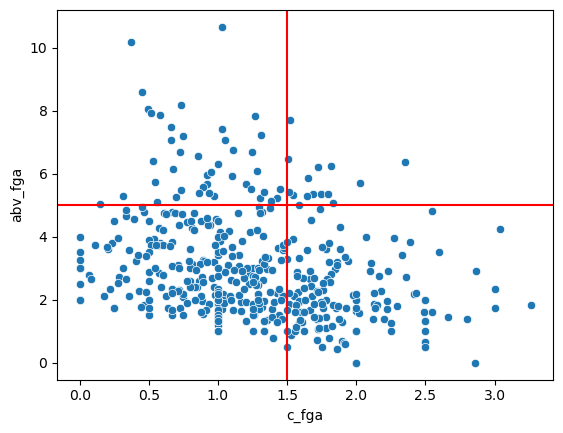

In [128]:
sns.scatterplot(data =d, x=d.c_fga ,y=d.abv_fga)
plt.axvline(x=1.5,ymin=0, ymax=11,color='red')
plt.axhline(y=5,xmin=0,xmax=4,color='red')
plt.show()

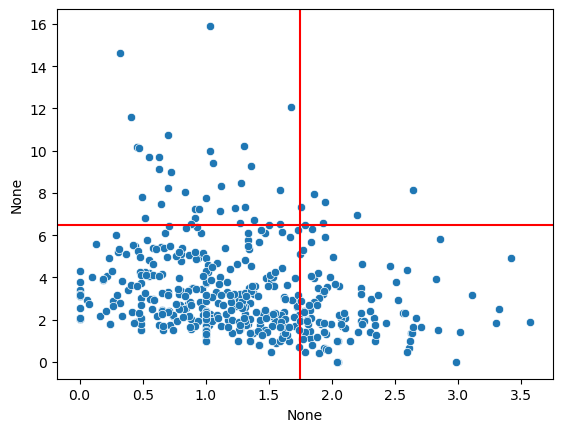

In [129]:
d =p23.groupby(ind)[['c_fga','abv_fga','pct3TeamShots']].mean()
sns.scatterplot(data =d, x=d.c_fga ** (1+d.pct3TeamShots),y=d.abv_fga ** (1+d.pct3TeamShots))
plt.axvline(x=1.75,ymin=0, ymax=11,color='red')
plt.axhline(y=6.5,xmin=0,xmax=4,color='red')
plt.show()

In [258]:
nba.showTables

,type,name,tbl_name,rootpage,sql
0,table,rosters,rosters,4,"CREATE TABLE rosters(\n teamId TEXT,\n s..."
1,table,shotsAllowed,shotsAllowed,2839,"CREATE TABLE shotsAllowed (team_id TEXT,\ngame..."
2,table,players,players,2,"CREATE TABLE players(\n player_id TEXT,..."
3,table,teams,teams,6,"CREATE TABLE teams(\n team_id TEXT,\n te..."
4,table,teamLog,teamLog,7,"CREATE TABLE teamLog(\n game_id TEXT,\n..."
5,table,plyrLogs,plyrLogs,123,"CREATE TABLE plyrLogs (player_id TEXT,\nteam_i..."
6,view,team_def,team_def,0,"CREATE VIEW team_def AS\nselect \nseason, subs..."
7,view,team_game,team_game,0,"CREATE VIEW team_game as \nSELECT season, game..."
8,view,pgames,pgames,0,"CREATE VIEW pgames AS\nSELECT name, teamAbrv a..."


In [16]:
teamD = pd.read_sql('select * from team_def',nba.conn)

In [20]:
temp = teamD.groupby(['game_number','game_id','season'])[['wide_fg3a','open_fg3a']].sum()

In [46]:
tempM = teamD.groupby(['game_number','game_id','season','home']).sum()

In [49]:
teamD['threesAllowed'] = teamD.crn_fgm + teamD.abv_fgm

In [543]:
nba.conn.execute('DROP VIEW pgames')
nba.conn.execute(open('data/sql/playerGameView.sql','r').read())
nba.conn.commit()

In [7]:
threes = pd.read_sql('''SELECT * 
                    FROM pgames
                    WHERE player_id||season in 
                    (SELECT player_id||season
                    FROM pgames 
                    where name = 'Marvin Williams'
                    group by player_id,season

                    --HAVING AVG(lc_fga + rc_fga + abv_fga) >= 3
                    
                    )''',
                     nba.conn)

In [25]:
threes.columns

Index(['name', 'team', 'game_number', 'season', 'home', 'player_id', 'team_id',
       'game_id', 'game_date', 'min', 'ftm', 'fta', 'reb', 'ast', 'tov', 'stl',
       'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus', 'dd2', 'td3',
       'offensiveRating', 'defensiveRating', 'usagePercentage', 'pace',
       'possessions', 'team_first', 'game_first', 'oreb', 'oreb_contest',
       'oreb_chances', 'oreb_chance_defer', 'avg_oreb_dist', 'dreb',
       'dreb_contest', 'dreb_chances', 'dreb_chance_defer', 'avg_dreb_dist',
       'ra_fgm', 'ra_fga', 'paint_fga', 'paint_fgm', 'mid_fgm', 'mid_fga',
       'lc_fgm', 'lc_fga', 'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga', 'opp_id',
       'game_id:1', 'ra_fgallowed', 'paint_fgallowed', 'mid_fgallowed',
       'lc_fgallowed', 'rc_fgallowed', 'abv_fgallowed', 'open_fg3a',
       'wide_fg3a', 'open_fg2a', 'wide_fg2a', 'open3_rate', 'wide3_rate',
       'daysBetweenGames', 'games_in_five', 'games_in_three', 'threesMade',
       'mvAvgThres', 'mvMinThrees

In [22]:
pd.read_sql('''SELECT player_id,game_id,abv_fga, NTILE (4) OVER (PARTITION BY player_id ORDER BY abv_fga) as percentile
                from plyrLogs''',nba.conn).tail(50)

,player_id,game_id,abv_fga,percentile
145276,2772,0021800487,5.000,4
145277,2772,0021800600,5.000,4
145278,2772,0021800665,5.000,4
145279,2772,0021800716,5.000,4
145280,2772,0021800950,5.000,4
145281,2772,0021801002,5.000,4
145282,2772,0021801028,5.000,4
145283,2772,0021900904,5.000,4
145284,2772,0022001050,5.000,4
145285,2772,0021700521,6.000,4


In [8]:
threes.head(50)

,name,team,game_number,season,home,player_id,team_id,game_id,game_date,min,...,open_fg2a,wide_fg2a,open3_rate,wide3_rate,daysBetweenGames,games_in_five,games_in_three,threesMade,mvAvgThres,mvMinThrees
0,Marvin Williams,CHA,1,2017-18,0,101107,1610612766,0021700003,2017-10-18,26.655,...,11.000,4.000,0.000,0.000,NaN,1,1,2.000,2.000,2
1,Marvin Williams,CHA,2,2017-18,1,101107,1610612766,0021700017,2017-10-20,15.805,...,8.000,1.000,0.000,0.000,1.000,2,2,0.000,1.000,0
2,Marvin Williams,CHA,4,2017-18,1,101107,1610612766,0021700055,2017-10-25,21.300,...,16.000,3.000,0.000,0.000,4.000,1,1,1.000,1.000,0
3,Marvin Williams,CHA,5,2017-18,1,101107,1610612766,0021700070,2017-10-27,25.633,...,10.000,4.000,0.000,0.000,1.000,2,2,1.000,1.000,0
4,Marvin Williams,CHA,6,2017-18,1,101107,1610612766,0021700088,2017-10-29,30.533,...,15.000,10.000,0.000,0.000,1.000,3,2,1.000,1.000,0
5,Marvin Williams,CHA,7,2017-18,0,101107,1610612766,0021700096,2017-10-30,25.067,...,21.000,6.000,0.000,0.000,0.000,3,2,1.000,1.000,0
6,Marvin Williams,CHA,8,2017-18,1,101107,1610612766,0021700105,2017-11-01,29.350,...,17.000,0.000,0.000,0.000,1.000,3,2,3.000,1.167,0
7,Marvin Williams,CHA,9,2017-18,0,101107,1610612766,0021700126,2017-11-03,25.750,...,10.000,2.000,0.000,0.000,1.000,3,2,1.000,1.333,1
8,Marvin Williams,CHA,10,2017-18,0,101107,1610612766,0021700143,2017-11-05,21.400,...,14.000,7.000,0.000,0.000,1.000,3,2,3.000,1.667,1
9,Marvin Williams,CHA,11,2017-18,0,101107,1610612766,0021700152,2017-11-07,27.847,...,13.000,4.000,0.000,0.000,1.000,3,2,1.000,1.667,1


In [471]:
idCols = ['name', 'team', 'game_number', 'season', 'player_id', 'team_id','opp_id',
       'game_id', 'game_date']
drops = ['offensiveRating','defensiveRating','possessions','game_first','team_first','oreb',
'oreb_contest',           
'oreb_chances',           
'oreb_chance_defer',      
'avg_oreb_dist',          
'dreb',                   
'dreb_contest',           
'dreb_chances',           
'dreb_chance_defer',     
'avg_dreb_dist','game_id:1']     

In [472]:
y = threes.threesMade

In [494]:
X = threes.drop(idCols + drops + ['threesMade'],axis=1)

In [495]:
X.isna().sum()

home                   0
min                    0
ftm                    0
fta                    0
reb                    0
ast                    0
tov                    0
stl                    0
blk                    0
blka                   0
pf                     0
pfd                    0
pts                    0
plus_minus             0
dd2                    0
td3                    0
usagePercentage     1831
pace                1831
ra_fgm               281
ra_fga               281
paint_fga            537
paint_fgm            537
mid_fgm              349
mid_fga              349
lc_fgm              2539
lc_fga              2539
rc_fgm              3307
rc_fga              3307
abv_fgm              252
abv_fga              252
ra_fgallowed           0
paint_fgallowed        0
mid_fgallowed          0
lc_fgallowed          56
rc_fgallowed          83
abv_fgallowed          0
open_fg3a            449
wide_fg3a            449
open_fg2a            449
wide_fg2a            449


In [496]:
#its the first game for every player will replace with median rest
X.daysBetweenGames = X.daysBetweenGames.fillna(2)
#there are 39 games where we do not have the open/wide information so we will remove those rows
print('{} games missing'.format(threes[X.wide_fg2a.isna()].game_id.nunique()))
X = X[X.open_fg3a.notna()]
#remaining are actual zero values
X = X.fillna(0)
#match indicies of x and y
y = y.loc[X.index]
X.isna().sum()

39 games missing


home                0
min                 0
ftm                 0
fta                 0
reb                 0
ast                 0
tov                 0
stl                 0
blk                 0
blka                0
pf                  0
pfd                 0
pts                 0
plus_minus          0
dd2                 0
td3                 0
usagePercentage     0
pace                0
ra_fgm              0
ra_fga              0
paint_fga           0
paint_fgm           0
mid_fgm             0
mid_fga             0
lc_fgm              0
lc_fga              0
rc_fgm              0
rc_fga              0
abv_fgm             0
abv_fga             0
ra_fgallowed        0
paint_fgallowed     0
mid_fgallowed       0
lc_fgallowed        0
rc_fgallowed        0
abv_fgallowed       0
open_fg3a           0
wide_fg3a           0
open_fg2a           0
wide_fg2a           0
daysBetweenGames    0
games_in_five       0
games_in_three      0
dtype: int64

In [504]:
X['threesMade'] = y

<Axes: >

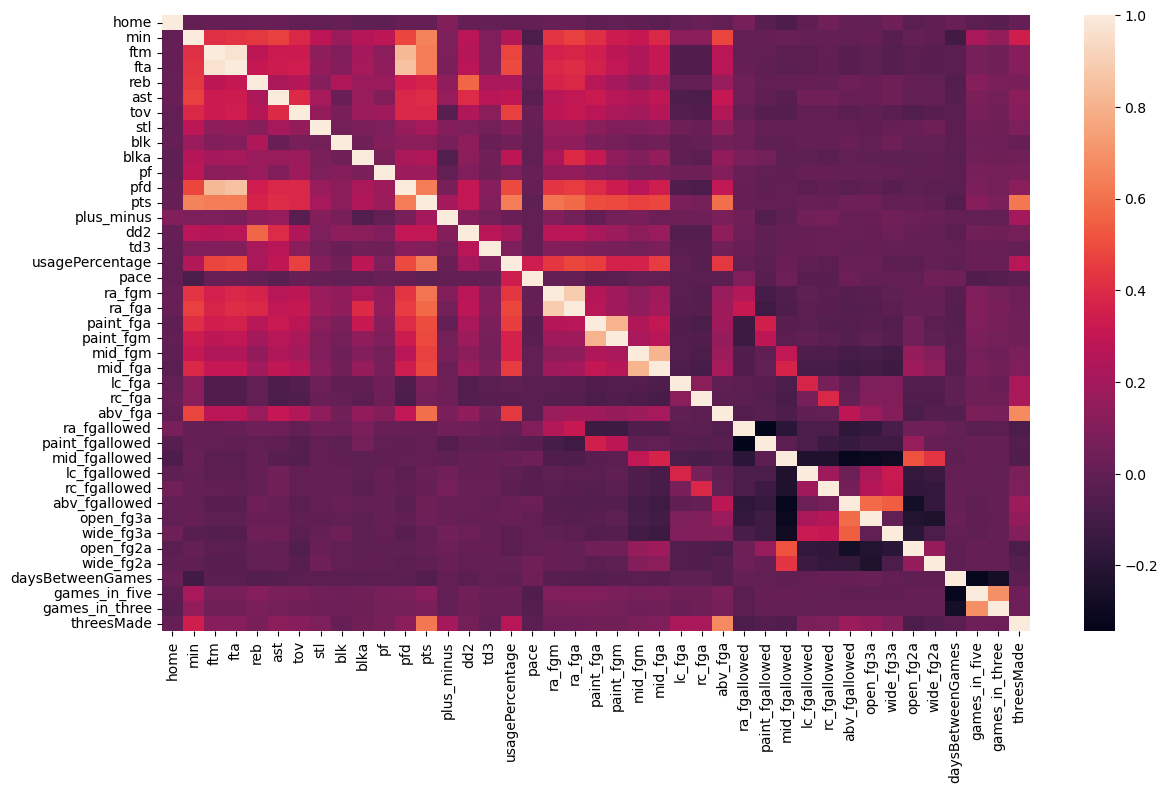

In [510]:
plt.figure(figsize=(14,8))
sns.heatmap(X.filter([col for col in X.columns if col not in ['abv_fgm','rc_fgm','lc_fgm']]).corr())

In [64]:
p = pd.read_sql(''' 
                SELECT player_id, season,
                --percentiles above the break threes and corner threes
                MAX(CASE WHEN abv_percentile = 1 then abv_fga END) as abv_fga_onep,
                MAX(CASE WHEN abv_percentile = 2 then abv_fga END) as abv_fga_twop,
                MAX(CASE WHEN abv_percentile = 3 then abv_fga END) as abv_fga_threep,
                MAX(CASE WHEN abv_percentile = 4 then abv_fga END) as abv_fga_fourp,
                MAX(CASE WHEN abv_percentile = 5 then abv_fga END) as abv_fga_fivep,
                MAX(CASE WHEN abv_percentile = 6 then abv_fga END) as abv_fga_sixp,
                
                MAX(CASE WHEN crn_percentile = 1 then crn_fga END) as crn_fga_onep,
                MAX(CASE WHEN crn_percentile = 2 then crn_fga END) as crn_fga_twop,
                MAX(CASE WHEN crn_percentile = 3 then crn_fga END) as crn_fga_threep,
                MAX(CASE WHEN crn_percentile = 4 then crn_fga END) as crn_fga_fourp,
                MAX(CASE WHEN crn_percentile = 5 then crn_fga END) as crn_fga_fivep,
                MAX(CASE WHEN crn_percentile = 6 then crn_fga END) as crn_fga_sixp
                FROM
                    (
                    SELECT 
                    --group bys
                    player_id,season,abv_fga,lc_fga + rc_fga as crn_fga,
                    --percentiles
                    NTILE(6) OVER (PARTITION BY player_id,season ORDER BY abv_fga) AS abv_percentile,
                    NTILE(6) OVER (PARTITION BY player_id,season ORDER BY lc_fga + rc_fga) AS crn_percentile
                    
                    FROM plyrLogs
                    JOIN (select game_id,season from teamLog) USING (game_id) ) og
                GROUP BY player_id, season
                

''',nba.conn
)

In [54]:
threes[threes.player_id=='101107'].groupby(['name','season']).abv_fga.describe(percentiles=np.arange(.16667,1,.16667))

count  mean   std   min  16.667%  33.334%   50%  \
name            season                                                     
Marvin Williams 2017-18 77.000 2.844 1.590 0.000    1.000    2.000 2.000   
                2018-19 75.000 3.387 1.931 0.000    2.000    2.000 3.000   
                2019-20 18.000 1.278 1.018 0.000    0.000    1.000 1.000   

                         50.001%  66.668%  83.335%   max  
name            season                                    
Marvin Williams 2017-18    2.001    3.000    4.335 7.000  
                2018-19    3.000    4.000    5.668 8.000  
                2019-20    1.000    2.000    2.000 4.000

In [65]:
p.head(50)

,player_id,season,abv_fga_onep,abv_fga_twop,abv_fga_threep,abv_fga_fourp,abv_fga_fivep,abv_fga_sixp,crn_fga_onep,crn_fga_twop,crn_fga_threep,crn_fga_fourp,crn_fga_fivep,crn_fga_sixp
0,101106,2017-18,0.000,0.000,0.000,0.000,0.000,0.000,NaN,NaN,NaN,0.000,0.000,0.000
1,101106,2018-19,0.000,0.000,0.000,0.000,0.000,0.000,NaN,0.000,0.000,0.000,0.000,0.000
2,101107,2017-18,1.000,2.000,2.000,3.000,5.000,7.000,NaN,0.000,1.000,1.000,2.000,5.000
3,101107,2018-19,2.000,2.000,3.000,4.000,6.000,8.000,0.000,1.000,1.000,2.000,3.000,5.000
4,101107,2019-20,0.000,1.000,1.000,2.000,2.000,4.000,0.000,1.000,1.000,1.000,2.000,5.000
5,101108,2017-18,3.000,4.000,5.000,6.000,8.000,10.000,0.000,0.000,1.000,2.000,2.000,3.000
6,101108,2018-19,3.000,4.000,5.000,6.000,7.000,10.000,0.000,1.000,1.000,1.000,2.000,3.000
7,101108,2019-20,2.000,3.000,3.000,4.000,5.000,8.000,0.000,0.000,0.000,1.000,1.000,2.000
8,101108,2020-21,1.000,2.000,3.000,4.000,5.000,7.000,0.000,0.000,0.000,0.000,1.000,4.000
9,101108,2021-22,1.000,2.000,3.000,3.000,4.000,8.000,0.000,0.000,0.000,0.000,1.000,1.000


In [479]:
from sklearn.preprocessing import Normalizer,StandardScaler

In [480]:
#baseline with just the values getting normalized 
norm = Normalizer()
stnd = StandardScaler()
for col in X.columns:
    if col !='home':
        vals = X[col].values.reshape(-1,1)
        X[col] = stnd.fit_transform(vals)

In [481]:
model = sm.MNLogit(endog = y,exog = X)
results = model.fit()

/Users/ericcoxon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3057: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
/Users/ericcoxon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3058: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


         Current function value: nan
         Iterations: 35


/Users/ericcoxon/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [486]:
rs

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             threesMade   No. Observations:                80295
Model:                        MNLogit   Df Residuals:                    79693
Method:                           MLE   Df Model:                          588
Date:                Mon, 09 Sep 2024   Pseudo R-squ.:                     nan
Time:                        06:47:43   Log-Likelihood:                    nan
converged:                      False   LL-Null:                   -1.4108e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
====================================================================================
    threesMade=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
home                 1.0600      0.022     48.539      0.000       1.017       1.103
min                  0.5413      0.025     21.844      0.000       0.493       0.590
ftm                 12.1322      1.797      6.750      0.000       8.609      15.655
fta                 -0.0906      0.048     -1.888      0.059      -0.185       0.003
reb                 -0.0085      0.015     -0.549      0.583      -0.039       0.022
ast                 -0.0054      0.015     -0.351      0.726      -0.035       0.025
tov                 -0.0596      0.015     -3.919      0.000      -0.089      -0.030
stl                  0.0194      0.012      1.605      0.109      -0.004       0.043
blk                  0.0088      0.012      0.763      0.446      -0.014       0.031
blka                 0.0245      0.014      1.787      0.074      -0.002       0.051
pf                   0.0238      0.012      2.024      0.043       0.001       0.047
pfd                  0.0037      0.024      0.152      0.879      -0.044       0.051
pts                -41.8520      6.192     -6.759      0.000     -53.988     -29.717
plus_minus          -0.0444      0.012     -3.632      0.000      -0.068      -0.020
dd2                  0.0137      0.016      0.861      0.389      -0.017       0.045
td3                 -0.0291      0.012     -2.379      0.017      -0.053      -0.005
usagePercentage      0.1870      0.026      7.114      0.000       0.136       0.239
pace                -0.0565      0.014     -4.091      0.000      -0.084      -0.029
ra_fgm              16.6785      2.463      6.772      0.000      11.852      21.505
ra_fga              -0.1063      0.031     -3.441      0.001      -0.167      -0.046
paint_fga           -0.0981      0.024     -4.136      0.000      -0.145      -0.052
paint_fgm           10.5542      1.559      6.770      0.000       7.499      13.610
mid_fgm              9.9452      1.468      6.774      0.000       7.068      12.823
mid_fga             -0.0849      0.023     -3.660      0.000      -0.130      -0.039
lc_fgm               7.5610      1.038      7.288      0.000       5.528       9.595
lc_fga              -0.0139      0.017     -0.812      0.417      -0.047       0.020
rc_fgm               7.2612      0.995      7.294      0.000       5.310       9.212
rc_fga               0.0132      0.017      0.773      0.439      -0.020       0.047
abv_fgm             20.8142      2.955      7.044      0.000      15.022      26.606
abv_fga             -0.1027      0.024     -4.212      0.000      -0.150      -0.055
ra_fgallowed        -0.0217      0.015     -1.440      0.150      -0.051       0.008
paint_fgallowed      0.0167      0.014      1.166      0.244      -0.011       0.045
mid_fgallowed        0.0172      0.018      0.962      0.336      -0.018       0.052
lc_fgallowed         0.0589      0.016      3.637      0.000       0.027       0.091
rc_fgallowed         0.0530      0.016      3.276      0.001       0.021       0.085
abv_fgallow

In [ ]:
rs = results.summary()
rhtml = rs.tables[1].as_html()
df = pd.read_html(rhtml,header=0,index_col=0)[0]

In [ ]:
keeps =['home','usuagePercentage','pace','lc_fga','rc_fga','abv_fga','ra_fgallowed','paint_fgallowed','mid_fgallowed',
        'lc_fgallowed','rc_fgallowed','abv_fgallowed','open_fg3a','wide_fg3a','open_fg2a','wide_fg2a','daysBetweenGames','games_in_five',
        'games_in_three','mvAvgThres','mvMinThrees'

In [546]:
for idx in df.index:
    print(df.loc[idx])

                  coef   std err        z  P>|z|     [0.025    0.975]
threesMade=1                                                         
home            1.0600     0.022   48.539  0.000      1.017     1.103
home            1.4555     0.045   32.637  0.000      1.368     1.543
home           -0.1891     0.051   -3.744  0.000     -0.288    -0.090
home           -1.3114     0.054  -24.410  0.000     -1.417    -1.206
home           -2.0771     0.058  -35.842  0.000     -2.191    -1.964
home           -2.5592     0.064  -40.121  0.000     -2.684    -2.434
home           -3.1150     0.080  -39.075  0.000     -3.271    -2.959
home           -3.5556     0.107  -33.251  0.000     -3.765    -3.346
home           -3.8727     0.160  -24.263  0.000     -4.186    -3.560
home           -4.5378     0.258  -17.565  0.000     -5.044    -4.031
home           -4.9249     0.360  -13.683  0.000     -5.630    -4.219
home           -5.2821     0.580   -9.102  0.000     -6.419    -4.145
home           -6.35

In [408]:
dsC = 41

In [458]:
df

,coef,std err,z,P>|z|,[0.025,0.975]
threesMade=1,,,,,,
home,1.0593,0.022,48.206,0.000,1.016,1.102
min,0.4287,0.019,23.143,0.000,0.392,0.465
ftm,13.1146,1.955,6.708,0.000,9.283,16.947
fta,-0.0531,0.048,-1.113,0.266,-0.147,0.040
reb,-0.0079,0.015,-0.513,0.608,-0.038,0.022
...,...,...,...,...,...,...
open_fg2a,0.0761,0.069,1.107,0.268,-0.059,0.211
wide_fg2a,0.0661,0.062,1.059,0.290,-0.056,0.188
daysBetweenGames,0.0745,0.053,1.419,0.156,-0.028,0.177


In [463]:
df.index[:45]

Index(['home', 'min', 'ftm', 'fta', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus', 'dd2', 'td3', 'ra_fgm', 'ra_fga',
       'paint_fga', 'paint_fgm', 'mid_fgm', 'mid_fga', 'lc_fgm', 'lc_fga',
       'rc_fgm', 'rc_fga', 'abv_fgm', 'abv_fga', 'ra_fgallowed',
       'paint_fgallowed', 'mid_fgallowed', 'lc_fgallowed', 'rc_fgallowed',
       'abv_fgallowed', 'open_fg3a', 'wide_fg3a', 'open_fg2a', 'wide_fg2a',
       'daysBetweenGames', 'games_in_five', 'games_in_three', 'threesMade=2',
       'home', 'min', 'ftm'],
      dtype='object', name='threesMade=1')

In [468]:
df.loc['fta'].reset_index()

,threesMade=1,coef,std err,z,P>|z|,[0.025,0.975]
0,fta,-0.0531,0.048,-1.113,0.266,-0.147,0.040
1,fta,-0.0753,0.105,-0.717,0.473,-0.281,0.130
2,fta,-0.1829,0.121,-1.517,0.129,-0.419,0.053
3,fta,-0.2957,0.125,-2.367,0.018,-0.541,-0.051
4,fta,-0.1495,0.129,-1.162,0.245,-0.402,0.103
5,fta,-0.0953,0.133,-0.715,0.474,-0.356,0.166
6,fta,-0.2265,0.144,-1.572,0.116,-0.509,0.056
7,fta,-0.2245,0.156,-1.438,0.150,-0.530,0.081
8,fta,-0.2545,0.177,-1.436,0.151,-0.602,0.093
9,fta,-0.2684,0.193,-1.392,0.164,-0.646,0.109


In [168]:
p23['totalThrees'] = p23['lc_fga']+p23['rc_fga'] + p23['abv_fga']

/var/folders/y5/cm5rrvr94yx214kzmtmsbvz40000gn/T/ipykernel_86746/2643172691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p23['totalThrees'] = p23['lc_fga']+p23['rc_fga'] + p23['abv_fga']


In [148]:
temp = threes.to_frame().join(p23.pct3TeamShots)
temp.columns = ['threesMade','pct3TeamShots']

In [176]:
med = p23.groupby('name')[['lc_fga','rc_fga','abv_fga','totalThrees']].transform('median')['totalThrees']

In [208]:
p23.loc[[x for x in np.where((med>=2) & (med<5),med.index,1) if x!=1]].groupby(['player_id','name'])[['totalThrees']].describe()

totalThrees                                      \
                                   count  mean   std   min   25%   50%   75%   
player_id name                                                                 
101108    Chris Paul              52.000 3.827 1.465 2.000 3.000 3.500 5.000   
1626145   Tyus Jones              54.000 4.167 1.901 2.000 3.000 4.000 5.000   
1626153   Delon Wright             6.000 4.333 2.066 2.000 3.250 4.000 4.750   
1626157   Karl-Anthony Towns      62.000 5.258 2.919 2.000 3.000 4.000 6.750   
1626167   Myles Turner            71.000 4.366 2.072 2.000 3.000 4.000 5.000   
...                                  ...   ...   ...   ...   ...   ...   ...   
203994    Jusuf Nurkic            25.000 2.800 1.258 2.000 2.000 2.000 3.000   
203995    Vasilije Micic          25.000 3.880 1.616 2.000 3.000 3.000 5.000   
203999    Nikola Jokic            54.000 3.852 1.947 2.000 2.000 3.000 5.000   
204060    Joe Ingles              31.000 3.355 1.305 2.000 2.500 3.000 4.000   
204456    T.J. McConnell           9.000 2.222 0.667 2.000 2.000 2.000 2.000   

                                     
                                max  
player_id name                       
101108    Chris Paul          9.000  
1626145   Tyus Jones         10.000  
1626153   Delon Wright        8.000  
1626157   Karl-Anthony Towns 16.000  
1626167   Myles Turner       10.000  
...                             ...  
203994    Jusuf Nurkic        6.000  
203995    Vasilije Micic      7.000  
203999    Nikola Jokic        8.000  
204060    Joe Ingles          7.000  
204456    T.J. McConnell      4.000  

[331 rows x 8 columns]

In [158]:
model = ols('threesMade ~ c_fgaabv_fga'pct3TeamShots',data=temp)
results = model.fit()

PatsyError: Error evaluating factor: NameError: name 'c_fga' is not defined
    threesMade ~ c_fga ^ (1+pct3TeamShots) + abv_fga ^ (1+pct3TeamShots)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^

In [156]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             threesMade   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                 1.046e+04
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:48:33   Log-Likelihood:                -22732.
No. Observations:               14292   AIC:                         4.547e+04
Df Residuals:                   14290   BIC:                         4.548e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1672      0.020      8.555      0.000       0.129       0.206
pct3TeamShots    22.3870      0.219    102.291      0.000      21.958      22.816
==============================================================================
Omnibus:                     1567.201   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14523.184
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                       7.937   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
d[(d.c_fga ** (1+d.pct3TeamShots)>1) & (d.abv_fga ** (1+d.pct3TeamShots)>6)]

,,,c_fga,abv_fga,pct3TeamShots
player_id,name,season,,,
1627741,Buddy Hield,2023-24,1.424,5.242,0.091
1627749,Dejounte Murray,2023-24,1.744,5.346,0.096
1628368,De'Aaron Fox,2023-24,1.110,6.740,0.111
1628374,Lauri Markkanen,2023-24,1.509,6.455,0.124
1628401,Derrick White,2023-24,1.542,5.319,0.086
1628970,Miles Bridges,2023-24,1.385,5.123,0.121
1628978,Donte DiVincenzo,2023-24,2.354,6.367,0.133
1629008,Michael Porter Jr.,2023-24,1.513,5.423,0.111
1629018,Gary Trent Jr.,2023-24,1.200,5.683,0.142


In [83]:
d[(d.c_fga>=1.5) & (d.abv_fga>4)]

,,,c_fga,abv_fga
player_id,name,season,,
1627736,Malik Beasley,2023-24,3.041,4.233
1627749,Dejounte Murray,2023-24,1.744,5.346
1628374,Lauri Markkanen,2023-24,1.509,6.455
1628398,Kyle Kuzma,2023-24,1.588,5.000
1628401,Derrick White,2023-24,1.542,5.319
1628960,Grayson Allen,2023-24,1.886,4.314
1628969,Mikal Bridges,2023-24,2.545,4.805
1628978,Donte DiVincenzo,2023-24,2.354,6.367
1629008,Michael Porter Jr.,2023-24,1.513,5.423


In [ ]:
sns.scatterplot(d)
plt.show()

In [ ]:
p23.groupby('game_number')[['abv_fga','lc_fga','rc_fga','ts']]

In [ ]:
df23[df23.db23==-1]

In [ ]:
f23 = final.loc[dinds.get('i2023'),:]

In [ ]:
f23['dbgrp'] = kmd['Run_3']['labels']

In [ ]:
f23.dbgrp.value_counts()

In [ ]:
f23[f23.dbgrp.isin([2])].name.unique()

In [ ]:
from statsmodels.api.regress import OLS


In [ ]:
non3 = [col for col in normData.columns if (re.search('abv_fg',col)==None) & (re.search('c_fg',col)==None)]

In [ ]:
X = normData.filter(non3)

In [ ]:
y = data.rc_fgm + data.lc_fgm + data.abv_fgm

In [ ]:
model = OLS(y.loc[dinds.get('i2023')],X.loc[dinds.get('i2023')])
results = model.fit()

In [ ]:
data[(data.season=='2023-24') & (data.allstars!=0)]

In [ ]:
data17['grp15'] =  sil_score['iter_15']['labels']

In [ ]:
pSeason = plog.groupby(ind).median().reset_index()

In [ ]:
pSeason['grp3'] = sil_score['iter_3']['labels']

In [ ]:
pSeason.grp3.value_counts()

In [ ]:
chcols = ['pts','rc_fga','lc_fga','abv_fga','usagePercentage']
pSeason[pSeason.grp15.isin([1,2])].groupby('grp15')[chcols].describe()

In [ ]:
from nba_api.stats.endpoints import PlayerProfileV2
def update_undrafted_year(pids):
    for pid in tqdm(pids):
        try:
            dy = PlayerProfileV2(pid).get_data_frames()[0].SEASON_ID.min()[:4]
            nba.conn.execute(''' UPDATE players
            SET draft_year = '{}'
            where player_id  = '{}'

            '''.format(dy,pid))
            nba.conn.commit()
        except:
            print('No Data for: {}'.format(demo[demo.player_id == pid].name))

In [ ]:
def update_demo_data(plog):
    plog['season_age'] = [(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days/ 365.25 for season,bday in zip(plog.season.values,plog.birthday)]
    plog['exp'] = plog.season.str[:4].astype(int) - plog.draft_year.astype(int)

In [ ]:
pd.read_sql('select * from pgames',nba.conn)

In [ ]:
def award_counts(demo,cols=None):
    '''
    Inputs: DF at season level, will be using season and the columns to count awards, will default to all awards
    Output: new dataframe with count columns replacings the columns for each instance
    '''
    awards = ['allstars', 'allnba_first','allnba_second', 'allnba_third', 'alld_first', 'alld_second', 'mip',
       'dpoy', 'mvp', 'finals_mvp']
    demo = demo.fillna('N/A')
    if cols == None:
        cols = awards
    lasts = ['allstars', ['allnba_first','allnba_second', 'allnba_third'],['alld_first', 'alld_second'],'mvp','dpoy']
    #This is checking to find the last time they were all-star, all-nba, all-d, mvp or dpoy, goes first to use years
    for lst in lasts:
        if isinstance(lst,str):
            demo['last_'+lst] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in zip(demo.season,demo[lst])]
        else:
            name = lst[0][:lst[0].find('_')]
            grp = zip(demo.season,[','.join(x) for x in demo.filter(lst).values])
            demo['last_'+name] = [1 if int(season[:4]) - int(max([x for x in team.split(',') if x < season]+['2000-01'])[:4]) < 3 else 0
            for  season,team in grp]
    #This goes through every award and will update the column with a count instead of the string of instances
    for col in cols:
        demo[col] = [len([a for a in awrd.split(',') if a < season]) for season,awrd in zip(demo.season,demo[col])]
    
    return demo

In [ ]:

award_counts(t)
            

In [ ]:
t['exp'] = [int(seas[:4]) - draft for seas,draft  in zip(t.season,t.draft_year) ]
t['age'] = [t.birthday - draft for seas,draft  in zip(t.season,t.birthday) ]

In [ ]:
(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(birthday)[0]).days / 365.25

In [ ]:
[(dt.datetime(int(season[:4]),10,1) - pd.to_datetime(bday)).days/ 365.25 for season,bday in zip(t.season.values,t.birthday)]